In [4]:
import pandas as pd 
import numpy as np
import glob
import ast
import random
import matplotlib.pyplot as plt
import matplotlib.colors
from numpy.polynomial import polynomial as P
from scipy.interpolate import splprep, splev
from scipy.integrate import quad
from scipy.spatial import distance
import surface_distance as sd
import similaritymeasures
import seaborn as sns
import math
from scipy.interpolate import make_interp_spline, BSpline
from sklearn import preprocessing as pre
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [5]:
files = glob.glob('../data/geometry_results_dl/*.csv')
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs, ignore_index=True)

In [6]:
# print df column names
print(df.columns)


Index(['filename', 'project_ID', 'slice_number', 'level',
       'cranial_vb_diameter', 'caudal_vb_diameter',
       'cranial_vb_midline_inclination', 'caudal_vb_midline_inclination',
       'cranial_vb_area', 'caudal_vb_area', 'cranial_vb_height',
       'caudal_vb_height', 'ivd_diameter', 'ivd_area', 'ivd_bulge_area',
       'ivd_bulge_ratio', 'central_ivd_area', 'ivd_height', 'ivd_height_index',
       'ivd_height_to_diameter_ratio', 'ivd_inclination',
       'cranial_endplate_line', 'caudal_endplate_line',
       'mean_signal_intensity', 'normalised_delta_si', 'mu',
       'motion_segment_ID'],
      dtype='object')


40523
Project ID: P0741_10950
Project ID: P0741_10950
Length cranial_x:  41
Length cranial_cont_avg_vectors:  0
Length cranial_slope_differences:  39


IndexError: list index out of range

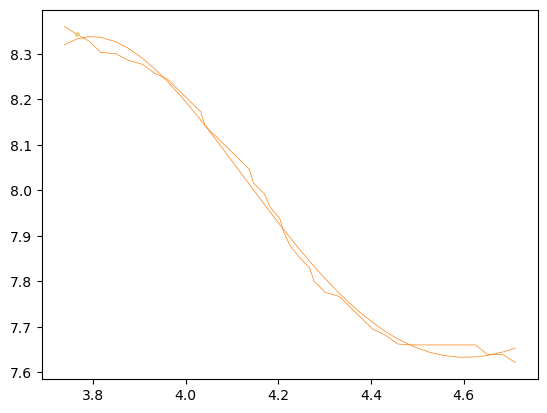

In [3]:
def fit_endplate_lines(df, index, cranial_caudal, order, print_info = False):

    location = f'{cranial_caudal}_endplate_line'
    endplate = df[location][index]
    # vb_height = df[f'{cranial_caudal}_vb_height'][index] 
    vb_height = df['cranial_vb_height'][index] # scaling only by the cranial VB height for the purposes of plotting

    # convert the line string to a list of tuples
    endplate = ast.literal_eval(endplate)

    # convert the list of tuples to a numpy array
    endplate = np.array(endplate)

    # scale endplate using the value for the IVD height
    endplate = endplate / vb_height

    endplate_x = endplate[:,0]

    endplate_y = endplate[:,1]


    # get a new endplate line that consists of equispaced points along the original line to minimise the pixelation effect:
    xd = np.diff(endplate_x)
    yd = np.diff(endplate_y)
    dist = np.sqrt(xd**2+yd**2)
    u = np.cumsum(dist)
    u = np.hstack([[0],u])
    n_points = round(30 * u[-1]) # choose the number of points based on the total length of the line (longer lines get more points)
    # print('Endplate length: ', u[-1])
    # print(n_points)
    t = np.linspace(0,u.max(),n_points)
    endplate_x = np.interp(t, u, endplate_x)
    endplate_y = np.interp(t, u, endplate_y)

    # remove some points from either end of the line to reduce impact of the corners
    n_to_remove = n_points // 8
    endplate_x = endplate_x[n_to_remove:-n_to_remove]
    endplate_y = endplate_y[n_to_remove:-n_to_remove]
        
    # fit a straight line to the endplate line
    coefs_1, polynomial_fit_error_1 = P.polyfit(endplate_x, endplate_y, 1, full=True)
    ffit_1 = P.Polynomial(coefs_1)

    # fit an nth order polynomial to the endplate line
    coefs_2, polynomial_fit_error_2 = P.polyfit(endplate_x, endplate_y, order, full=True)
    ffit_2 = P.Polynomial(coefs_2)

    poly_line = np.zeros((len(endplate_x), 2))
    poly_line[:, 0] = endplate_x
    poly_line[:, 1] = ffit_2(endplate_x)

    # Package similaritymeasures for calculating the area between two curves (above and below)
    # https://pypi.org/project/similaritymeasures/
    area_endplate_poly_line = similaritymeasures.area_between_two_curves(endplate, poly_line)

    # Other metrics from the same package:
    # quantify the difference between the two curves using PCM
    mapping = similaritymeasures.pcm(endplate, poly_line)

    # quantify the difference between the two curves using
    # Discrete Frechet distance
    frechet = similaritymeasures.frechet_dist(endplate, poly_line)

    # quantify the difference between the two curves using
    # Curve Length based similarity measure
    curvelength = similaritymeasures.curve_length_measure(endplate, poly_line)

    straight_line = np.zeros((len(endplate_x), 2))
    straight_line[:, 0] = endplate_x
    straight_line[:, 1] = ffit_1(endplate_x)

    area_endplate_straight_line = similaritymeasures.area_between_two_curves(endplate, straight_line)

    area_poly_line_straight_line = similaritymeasures.area_between_two_curves(poly_line, straight_line)

    print("Project ID:", df['project_ID'][index])

    if print_info:
        print("Endplate: ", cranial_caudal)
        print("Slice number:", df['slice_number'][index])
        print("Motion segment:", df['level'][index])
        print("Sum of squared residuals straight line: ", polynomial_fit_error_1[0])
        print("Sum of squared residuals polynomial: ", polynomial_fit_error_2[0])
        print("Straight line coefficients: ", coefs_1)
        print("Polynomial coefficients: ", coefs_2)
        print("Area between endplate and polynomial line: ", area_endplate_poly_line)
        print("Primary curve mapping: ", mapping)
        print("Discrete Frechet distance: ", frechet)
        print("Curve length: ", curvelength)
        print("Area between endplate and straight line: ", area_endplate_straight_line)
        print("Area between polynomial line and straight line: ", area_poly_line_straight_line)


    return endplate_x, endplate_y, ffit_1, ffit_2

def get_vectors(x, y):
    vectors = []
    for idx in range(len(x)-1):
        x0, y0, xa, ya = x[idx], y[idx], x[idx+1], y[idx+1]
        vector = [x0, y0, xa, ya]
        vectors.append(vector)

def get_vectors_bidirectional(x, y, length):
    
    slopes = []
    vectors_a = []
    slopes_a = []
    vectors_b = []
    slopes_b = []
    
    # because the slopes between adjacent points can only be either 0, -0, 1 -1 due to the way the pixels are connected,
    # we need to get the slopes between every other point
    # this leave two points at the end missing and makes the slope at each point dependent on the points after it
    # so we need to do this twice, once going forward and once going backward
    # aterwards we will take the average of the two slopes at each point

    for idx in range(len(x)-1):
        x0, y0, xa, ya = x[idx], y[idx], x[idx+1], y[idx+1]
        # # print(x0, y0, xa, ya)
        # dx0, dy0 = xa-x0, ya-y0
        # # print(dx0, dy0)
        # if dx0 == 0 and dy0 == 0:
        #     norm = math.pi/2
        # else:
        #     norm = math.hypot(dx0, dy0) * 1/length
        # # print(norm)
        # dx0 /= norm
        # dy0 /= norm
        # # ax.plot((x0, x0-dy0), (y0, y0+dx0), color = colour)    # plot the normals

        # # get the slope of the line
        # if xa-x0 == 0:
        #     slope_a = 0
        # else:
        #     slope_a = (ya-y0)/(xa-x0)
        
        vector_a = [x0, y0, xa, ya]

        vectors_a.append(vector_a)
        # slopes_a.append(slope_a)

    # reverse the direction:
    x = x[::-1]
    y = y[::-1]
    for idx in range(len(x)-1):
        x1, y1, xb, yb = x[idx], y[idx], x[idx+1], y[idx+1]
        # dx1, dy1 = xb-x1, yb-y1
        # if dx1 == 0 and dy1 == 0:
        #     norm = math.pi/2
        # else:
        #     norm = math.hypot(dx1, dy1) * 1/length
        # dx1 /= norm
        # dy1 /= norm
        # # ax.plot((x1, x1-dy1), (y1, y1+dx1), color = colour)    # plot the normals

        # # get the slope of the line
        # if xb-x1 == 0:
        #     slope_b = 0
        # else:
        #     slope_b = (yb-y1)/(xb-x1)

        vector_b = [x1, y1, xb, yb]

        vectors_b.append(vector_b)
        # slopes_b.append(slope_b)

    return vectors_a, vectors_b, # slopes_a, slopes_b 

def get_vector_avg(vector_a, vector_b):
    # get the average of the two vectors
    avg_slopes = []
    avg_vectors = []
    for idx in range(len(vector_a)-1):
        x_avg = (vector_a[:-1][idx][2] + vector_b[::-1][1:][idx][2])/2
        y_avg = (vector_a[:-1][idx][3] + vector_b[::-1][1:][idx][3])/2
        vector_avg = [vector_a[:-1][idx][0], vector_a[:-1][idx][1], x_avg, y_avg]

        if vector_avg[2] - vector_avg[0] == 0:
            avg_slope = 0
        else:
            avg_slope = (vector_avg[3] - vector_avg[1])/(vector_avg[2] - vector_avg[0])
        avg_slopes.append(math.degrees(avg_slope))
        
    return avg_slopes, avg_vectors

def get_slope_differences(contour_avg_slopes, poly_avg_slopes):
    # average_slopes = []
    # for idx in range(len(slopes_a)-1): # the start and stop points are offset by one since the list of points was reversed back:
    #     average_slope = (slopes_a[:-1][idx] + slopes_b[::-1][1:][idx])/2
    #     average_slope = math.degrees(average_slope)
    #     average_slopes.append(average_slope)

    # poly_average_slopes = []
    # for idx in range(len(poly_slopes_a)-1):
    #     poly_average_slope = (poly_slopes_a[:-1][idx] + poly_slopes_b[::-1][1:][idx])/2
    #     poly_average_slope = math.degrees(poly_average_slope)
    #     poly_average_slopes.append(poly_average_slope)

    #  get the absolute difference in slopes
    abs_diff_slopes = []
    for idx in range(len(contour_avg_slopes)):
        abs_diff_slope = 180 - abs(abs(contour_avg_slopes[idx] - poly_avg_slopes[idx]) - 180)
        abs_diff_slopes.append(abs_diff_slope)
    
    return abs_diff_slopes, contour_avg_slopes, poly_avg_slopes

# generate a random index from the df
random_index = random.randint(0, len(df))
# random_index = 23526 # Schmorl's node
# random_index = 8996 # Schmorl's node
# random_index = 3186 # Very large Schmorl's node
# random_index = 37149 # very concave or possibly Schmorl's node
# random_index = 5164 # Classic polynomial curve
# random_index = 41660 # Large curve but no focal defect
# random_index = 33695 # Large curve but no focal defect
random_index = 40523 # angle results look wrong
print(random_index)
project_ID = df['project_ID'][random_index]
slice_number = df['slice_number'][random_index]
level = df['level'][random_index]

cranial_x, cranial_y, cranial_ffit_1, cranial_ffit_2 = fit_endplate_lines(df, random_index, 'cranial', 4)
caudal_x, caudal_y, caudal_ffit_1, caudal_ffit_2 = fit_endplate_lines(df, random_index, 'caudal', 4)

# cranial_x, cranial_y, cranial_ffit_1, cranial_ffit_2 = fit_endplate_lines(df, random_index, 'cranial', 4)
# cranial_slopes_a, cranial_slopes_b = get_normals(cranial_x, cranial_y, 0.1)
# cranial_poly_slopes_a, cranial_poly_slopes_b = get_normals(cranial_x, cranial_ffit_2(cranial_x), 0.1)

cranial_cont_vectors_a, cranial_cont_vectors_b = get_vectors(cranial_x, cranial_y, 0.1)
cranial_poly_vectors_a, cranial_poly_vectors_b = get_vectors(cranial_x, cranial_ffit_2(cranial_x), 0.1)

cranial_cont_avg_slopes, cranial_cont_avg_vectors = get_vector_avg(cranial_cont_vectors_a, cranial_cont_vectors_b)
cranial_poly_avg_slopes, cranial_poly_avg_vectros = get_vector_avg(cranial_poly_vectors_a, cranial_poly_vectors_b)

cranial_slope_differences, contour_avg_slopes, poly_avg_slopes = get_slope_differences(cranial_cont_avg_slopes, cranial_poly_avg_slopes)
# cranial_slope_differences, cranial_average_slopes, cranial_poly_average_slopes = get_slope_differences(cranial_slopes_a, cranial_slopes_b, cranial_poly_slopes_a, cranial_poly_slopes_b)

# caudal_x, caudal_y, caudal_ffit_1, caudal_ffit_2 = fit_endplate_lines(df, random_index, 'caudal', 4)
# caudal_slopes_a, caudal_slopes_b = get_normals(caudal_x, caudal_y, 0.1)
# caudal_poly_slopes_a, caudal_poly_slopes_b = get_normals(caudal_x, caudal_ffit_2(caudal_x), 0.1)
# caudal_slope_differences, caudal_average_slopes, caudal_poly_average_slopes = get_slope_differences(caudal_slopes_a, caudal_slopes_b, caudal_poly_slopes_a, caudal_poly_slopes_b)

############ Plotting ############
palette_tab10 = sns.color_palette("tab10", 10)
fig, ax = plt.subplots()
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=90)

s = 5
lw = 0.5

# plt.plot(cranial_x, cranial_y, label = "Bony endplate contour", linewidth = lw, color = palette_tab10[0], zorder = 1)
# plt.plot(caudal_x, caudal_y, linewidth = lw, color = palette_tab10[0])
# plt.scatter(cranial_x, cranial_y, s=s,  color = palette_tab10[0], zorder = 2)
# plt.scatter(caudal_x, caudal_y, s=s, color = palette_tab10[0],)
plt.plot(cranial_x, cranial_ffit_2(cranial_x), label = "4th order polynomial of best fit", linewidth = lw, color = palette_tab10[1], zorder = 5)
plt.plot(cranial_x, cranial_y, color = palette_tab10[1], linewidth = lw, zorder = 1)
# plt.plot(caudal_x, caudal_y, color = palette_tab10[1], linewidth = lw, zorder = 1)
# plt.plot(caudal_x, caudal_ffit_2(caudal_x), linewidth = lw, color = palette_tab10[1], zorder = 5)

# for i in range(len(cranial_cont_avg_slopes)):
#     print(cranial_cont_avg_slopes[i], cranial_poly_avg_slopes[i])
#     plt.plot((cranial_cont_avg_vectors[0], cranial_cont_avg_vectors[1]), (cranial_cont_avg_vectors[2], cranial_cont_avg_vectors[3]), color = palette_tab10[0])

print("Length cranial_x: ", len(cranial_x))
print("Length cranial_cont_avg_vectors: ", len(cranial_cont_avg_vectors))
print("Length cranial_slope_differences: ", len(cranial_slope_differences))

for i in range(len(cranial_slope_differences)):
    ax.scatter(cranial_x[i+1], cranial_y[i+1], c=cranial_slope_differences[i], s=s, cmap=cmap, norm=norm, zorder = 3)
    ax.plot((cranial_cont_avg_vectors[0], cranial_cont_avg_vectors[1]), (cranial_cont_avg_vectors[2], cranial_cont_avg_vectors[3]), color = palette_tab10[0])

# for i in range(len(caudal_slope_differences)):
#     ax.scatter(caudal_x[i+1], caudal_y[i+1], c=caudal_slope_differences[i], s=s, cmap=cmap, norm=norm, zorder = 3)

# plt.plot(cranial_x, cranial_ffit_1(cranial_x), label = "Straight line of best fit", color = palette_tab10[2])
# plt.plot(caudal_x, caudal_ffit_1(caudal_x), color = palette_tab10[2])

plt.axis('scaled')

x_min = min(cranial_x.min(), caudal_x.min()) - 0.3
x_max = max(cranial_x.max(), caudal_x.max()) + 0.3
y_min = min(cranial_y.min(), caudal_y.min()) - 0.3
y_max = max(cranial_y.max(), caudal_y.max()) + 0.3

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().invert_yaxis()
# plt.title('Fitted Bony Endplate Lines')
plt.legend()
# add a colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sm, cax=cax, label = "Difference in angle (radians)")
plt.show()
# fig.savefig(f'../../../Desktop/{project_ID}_IMG000{slice_number}_{level}_local_angle_difference.pdf',format='pdf')


In [32]:
for i in range(len(cranial_slope_differences)):
    print(f"Cranial {i+1} average: {cranial_average_slopes[i]}")
    print(f"Cranial {i+1} poly average: {cranial_poly_average_slopes[i]}")
    print(f"Cranial diff {i+1}: {cranial_slope_differences[i]}")


for i in range(len(caudal_slope_differences)):
    print(f"caudal {i+1} average: {caudal_average_slopes[i]}")
    print(f"caudal {i+1} poly average: {caudal_poly_average_slopes[i]}")
    print(f"caudal diff {i+1}: {caudal_slope_differences[i]}")


Cranial 1 average: -34.73192421770436
Cranial 1 poly average: 19.04486033638973
Cranial diff 1: 53.77678455409409
Cranial 2 average: -44.986236408660865
Cranial 2 poly average: 3.7609425413312394
Cranial diff 2: 48.747178949992104
Cranial 3 average: -31.394230064381528
Cranial 3 poly average: -10.24265799210934
Cranial diff 3: 21.151572072272188
Cranial 4 average: -17.75991839892252
Cranial 4 poly average: -23.74046379886626
Cranial diff 4: 5.980545399943736
Cranial 5 average: -23.41147326594202
Cranial 5 poly average: -35.746234170143886
Cranial diff 5: 12.334760904201858
Cranial 6 average: -29.707642219065715
Cranial 6 poly average: -45.73504180865053
Cranial diff 6: 16.027399589584803
Cranial 7 average: -35.03898287786279
Cranial 7 poly average: -53.98402508954554
Cranial diff 7: 18.945042211682733
Cranial 8 average: -42.37712559019759
Cranial 8 poly average: -60.69530714988463
Cranial diff 8: 18.318181559687048
Cranial 9 average: -57.2957795130818
Cranial 9 poly average: -65.961729

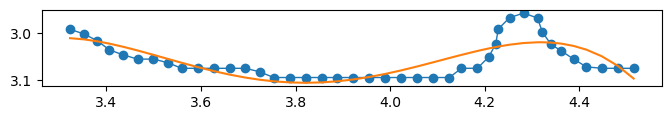

In [355]:
def get_normals(x, y, length, colour):
    
    slopes = []
    slopes_a = []
    slopes_b = []
    
    # because the slopes between adjacent points can only be either 0, -0, 1 -1 due to the way the pixels are connected,
    # we need to get the slopes between every other point
    # this leave two points at the end missing and makes the slope at each point dependent on the points after it
    # so we need to do this twice, once going forward and once going backward
    # aterwards we will take the average of the two slopes at each point

    for idx in range(len(x)-1):
        x0, y0, xa, ya = x[idx], y[idx], x[idx+1], y[idx+1]
        dx0, dy0 = xa-x0, ya-y0
        norm = math.hypot(dx0, dy0) * 1/length
        dx0 /= norm
        dy0 /= norm
        # ax.plot((x0, x0-dy0), (y0, y0+dx0), color = colour)    # plot the normals

        # get the slope of the line
        slope_a = (ya-y0)/(xa-x0)

        slopes_a.append(slope_a)

    # reverse the direction:
    x = x[::-1]
    y = y[::-1]
    for idx in range(len(x)-1):
        x1, y1, xb, yb = x[idx], y[idx], x[idx+1], y[idx+1]
        dx1, dy1 = xb-x1, yb-y1
        norm = math.hypot(dx1, dy1) * -1/length
        dx1 /= norm
        dy1 /= norm
        # ax.plot((x1, x1-dy1), (y1, y1+dx1), color = colour)    # plot the normals

        # get the slope of the line
        slope_b = (yb-y1)/(xb-x1)

        slopes_b.append(slope_b)

    return slopes_a, slopes_b 

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [8, 8]

ax.plot(cranial_x, cranial_y, linewidth = 1, color = palette_tab10[0])
ax.scatter(cranial_x, cranial_y)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
slopes_a, slopes_b = get_normals(cranial_x, cranial_y, 0.1, palette_tab10[0])

poly_slopes_a, poly_slopes_b = get_normals(cranial_x, cranial_ffit_2(cranial_x), 0.1, palette_tab10[1])

ax.plot(cranial_x, cranial_ffit_2(cranial_x), label = "4th order polynomial of best fit", color = palette_tab10[1])

plt.axis('scaled')
plt.gca().invert_yaxis()

plt.show()
# fig.savefig(f'../../../Desktop/{project_ID}_IMG000{slice_number}_{level}_angles_b.svg',format='svg')


47
[0.986696741365044, 0.35060787441781743, 1.0, 0.3418775009095798, 0.5036784792603928, 0.7573270115315887, 0.35939373348490267, 0.2959866145520327, 0.0, 0.2506932791146147, 0.40849145852237195, 0.0, 0.0, 0.0, 0.0, 0.24755251025175765, 0.41202376341880964, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.7573270115315756, -0.0030363604179538327, -1.0, -1.8439744355257235, -5.991684526382192, -0.9999999999999813, -0.3292802980363811, 0.35459092167024503, 2.92502430648276, 1.4229309387550388, 0.6352238380331958, 0.6657912675147033, 0.606467983129998, 0.09540690903548968, 0.0, 0.0, 0.7573270115316018, 0.0]
[0.35060787441781743, 1.0, 0.3418775009095798, 0.5036784792603928, 0.7573270115315887, 0.35939373348490267, 0.2959866145520327, -0.0, 0.2506932791146147, 0.40849145852237195, -0.0, -0.0, -0.0, -0.0, 0.24755251025175765, 0.41202376341880964, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.7573270115315756, -0.0030363604179538327, -1.0, -1.8439744355257235, 

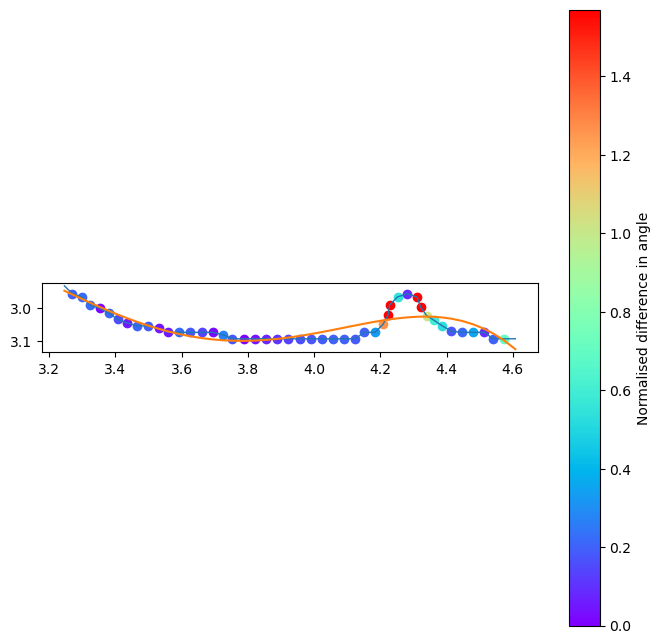

In [54]:
print(len(slopes_a))
print(slopes_a[:-1])
print(slopes_b[::-1][1:])
# print(poly_slopes_a)
# print(poly_slopes_b[::-1])
# print(slopes_a[1:-1])
# print(slopes_b[::-1][:-2])

# find the average of slopes_a and slopes_b
# While the endplate originally has n points, this gets reduced to two sets of sloped (one for each direction) with n-1 points
# so we need to average the slopes between each point in the two sets
# However, to get the average, we need to offset the start and stop points by one
# This reduces the number of points in each set by one, meaning the length of the average slopes list is n-2
average_slopes = []
for idx in range(len(slopes_a)-1): # the start and stop points are offset by one since the list of points was reversed back:
    average_slope = (slopes_a[:-1][idx] + slopes_b[::-1][1:][idx])/2
    average_slopes.append(average_slope)
print(len(average_slopes))
# print(average_slopes)

poly_average_slopes = []
for idx in range(len(poly_slopes_a)-1):
    average_slope = (poly_slopes_a[:-1][idx] + poly_slopes_b[::-1][1:][idx])/2
    poly_average_slopes.append(average_slope)
print(len(poly_average_slopes))
# print(poly_average_slopes)

#  get the absolute difference in slopes
abs_diff_slopes = []
for idx in range(len(average_slopes)):
    abs_diff_slope = abs(average_slopes[idx] - poly_average_slopes[idx])
    abs_diff_slopes.append(abs_diff_slope)

# print(abs_diff_slopes)
print("Sum of angle differences: ", sum(abs_diff_slopes))

# try to plot the difference in angles
fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = [8, 8]

cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=math.pi/2)
print(len(cranial_x))
print(len(cranial_y))
print(len(abs_diff_slopes))
for i in range(len(average_slopes)):
    ax.scatter(cranial_x[i+1], cranial_y[i+1], c=abs_diff_slopes[i], cmap=cmap, norm=norm)
plt.plot(cranial_x, cranial_y, label = "Bony endplate contour", linewidth = lw, color = palette_tab10[0], zorder = 1)
plt.plot(cranial_x, cranial_ffit_2(cranial_x), label = "4th order polynomial of best fit", color = palette_tab10[1])
# add a colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label = "Absolute difference in angle (radians)")
plt.axis('scaled')
plt.gca().invert_yaxis()

In [97]:
print(cranial_x)
print(cranial_x[::-1])

[18.99497207 19.20032312 19.30299864 20.22707836 20.32975389 20.43242941
 20.63778046 20.74045599 20.84313151 20.94580704 21.04848256 21.15115809
 21.25383361 21.35650914 21.56186019 21.66453571 21.97256228 22.07523781
 22.48593991 22.58861543 22.69129096 22.79396648 22.89664201 23.3073441
 23.41001963 24.23142383 24.33409935 24.43677488 24.69346369]
[24.69346369 24.43677488 24.33409935 24.23142383 23.41001963 23.3073441
 22.89664201 22.79396648 22.69129096 22.58861543 22.48593991 22.07523781
 21.97256228 21.66453571 21.56186019 21.35650914 21.25383361 21.15115809
 21.04848256 20.94580704 20.84313151 20.74045599 20.63778046 20.43242941
 20.32975389 20.22707836 19.30299864 19.20032312 18.99497207]


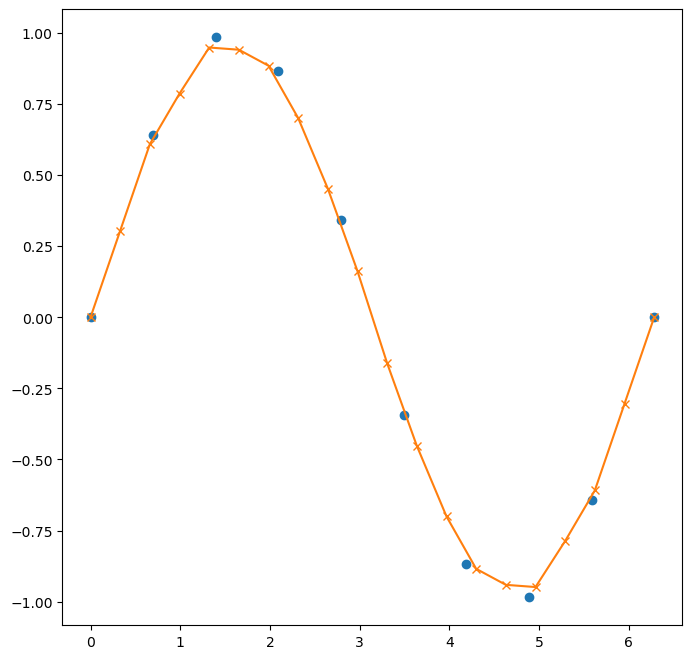

In [40]:
x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)
xvals = np.linspace(0, 2*np.pi, 20)
yinterp = np.interp(xvals, x, y)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o')
plt.plot(xvals, yinterp, '-x')
plt.show()